<a href="https://colab.research.google.com/github/HammadN98/pos-Inteligencia-Artificial-e-Computacional/blob/main/Aprendizado-Profundo/ELT575_Semana2_ES119826.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [24]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Usando: {device}")

Usando: /GPU:0


In [25]:
#ES119826
#ELT575_Semana2_ES119826

Houve muita diferença no desempenho da rede treinada quando comparado ao exemplo?

Experimente adicionar mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten e compare os resultados.

Seguindo o modelo modificado no item anterior, experimente adicionar um Dropout de 20% após cada camada MaxPooling. Comente os resultados obtidos.



# Importando dados

Aqui usaremos o dataset MNIST (https://en.wikipedia.org/wiki/MNIST_database), que consiste em imagens de dígitos de 0 a 9 escritos manualmente. As imagens desse dataset são na escala grayscale (possuindo um único canal), tendo dimensões 28 x 28 x 1

* Usaremos a versão disponível no tensorflow, mas nada impede que as imagens sejam carregadas de alguma pasta no próprio computador ou carregadas direto para a memória como um array multidimensional (esse último é desaconselhado devido ao volume de dados que serão manipulados durante o treinamento da rede)

## Baixando os dados

In [26]:
#Exemplo
# carregando dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

In [27]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Faremos algumas adequações para que os dados sejam usados no modelo de CNN. Basicamente, colocamos os valores dos pixels em uma escala de 0 a 1, visto que os valores originais dos pixels das imagens correspondem a uma escala de 0 a 255. Também transformamos nossa variável alvo em uma codificação one-hos

## Visualizando uma imagem

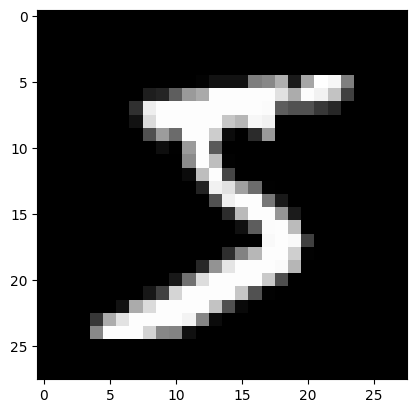

In [28]:
#Exemplo
plt.imshow(trainX[0], cmap='gray');

A imagem tem classificao de [6] = Sapo


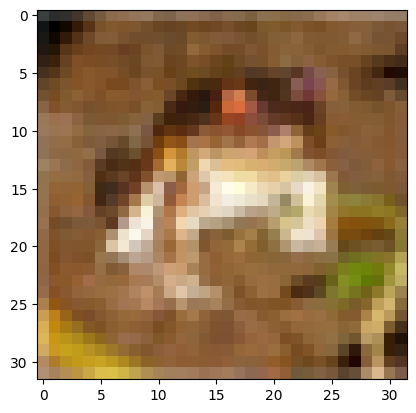

In [29]:
plt.imshow(X_train[0]);
print(f"A imagem tem classificao de {y_train[0]} = Sapo")

## Separando os dados

In [30]:
#Exemplo

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

# Convertendo valores dos pixels em float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

# transformando a variável alvo (target) para uma codificação one hot
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [31]:
# fazendo um reshape no dataset para ter um único canal
X_train = X_train.reshape((X_train.shape[0], 32, 32, 3))
X_test = X_test.reshape(( X_test.shape[0], 32, 32, 3))

# Convertendo valores dos pixels em float e normalizando
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') /  255.0


# transformando a variável alvo (target) para uma codificação one hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Construindo o modelo

O modelo usado será bem simples:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes (dígitos 0 a 9)


Para treinamento do modelo, usaremos o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [32]:
#Exemplo
# definindo modelo
def define_model_mnist():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

modelo_mnist = define_model_mnist()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
# definindo modelo
def define_model_cifar10():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

modelo_cifar = define_model_cifar10()

# Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9331 - loss: 0.2200 - val_accuracy: 0.9793 - val_loss: 0.0708
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9889 - loss: 0.0340 - val_accuracy: 0.9815 - val_loss: 0.0615
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9931 - loss: 0.0199 - val_accuracy: 0.9806 - val_loss: 0.0696
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9956 - loss: 0.0137 - val_accuracy: 0.9752 - val_loss: 0.1221
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9960 - loss: 0.0119 - val_accuracy: 0.9816 - val_loss: 0.1046
> 98.150
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9278 - loss: 0.2406 - val_accuracy: 0.9795 - val_loss: 0.0669
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9873 - loss: 0.0408 - val_accuracy: 0.9809 - val_loss: 0.0661
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9932 - loss: 

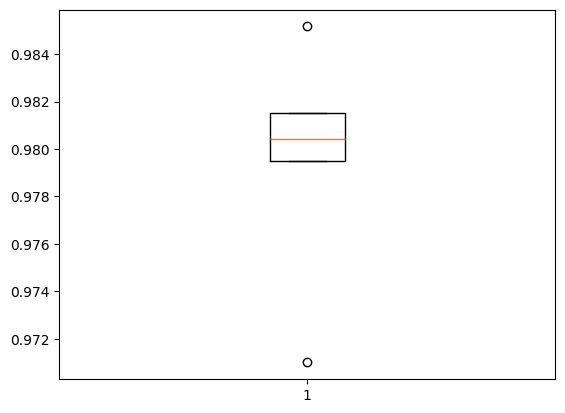

In [35]:
scores_mnist = []
histories_mnist = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model_mnist = define_model_mnist()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # treinamento do modelo
  history_mnist = model_mnist.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1, callbacks=[callback])

  # desempenho do modelo
  _, acc_mnist = model_mnist.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc_mnist * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores_mnist.append(acc_mnist)
  histories_mnist.append(history_mnist)

media_mnist = np.mean(scores_mnist)*100
std_mnist = np.std(scores_mnist)*100
print('Acurácia: média=%.3f desvio=%.3f' % (media_mnist, std_mnist))
plt.boxplot(scores_mnist)
plt.show()

In [36]:
def train(model, epochs:int = 10, batch_size:int = 32, X_train=X_train, y_train=y_train):
  scores = []
  histories = []

  # definindo a validação k-fold
  kfold = KFold(5, shuffle=True, random_state=1)

  # loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
  for train_ix, test_ix in kfold.split(X_train):



    # recorta dados de acordo com índices da k-fold
    train_data, train_target, val_data, val_target = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]

    # treinamento do modelo
    history = model.fit(train_data, train_target,
                    epochs=10, batch_size=32,
                    validation_data=(val_data, val_target),
                    verbose=1, callbacks=[callback])

    # desempenho do modelo
    _, acc = model.evaluate(val_data, val_target, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # armazena resultados de cada modelo treinado dentro da k-fold
    scores.append(acc)
    histories.append(history)
  return scores


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4530 - loss: 1.6116 - val_accuracy: 0.5857 - val_loss: 1.2175
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6557 - loss: 0.9939 - val_accuracy: 0.5578 - val_loss: 1.2732
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7347 - loss: 0.7561 - val_accuracy: 0.5852 - val_loss: 1.3590
> 58.570
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6253 - loss: 1.0563 - val_accuracy: 0.6394 - val_loss: 1.0492
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7285 - loss: 0.7735 - val_accuracy: 0.6366 - val_loss: 1.0964
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8036 - loss: 0.5721 - val_accuracy: 0.6394 - val_loss: 1.1230
> 63.940
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7098 - loss: 0.8370 - val_accuracy: 0.7166 - val_loss: 0.8147
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7862

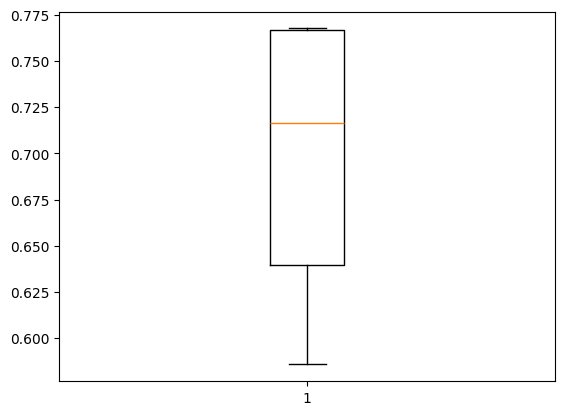

In [37]:
scores_cifar = train(model=modelo_cifar)
media_cifar = np.mean(scores_cifar)*100
std_cifar = np.std(scores_cifar)*100
print(f'Acurácia: média={media_cifar:.3f} desvio={std_cifar:.3f}')
plt.boxplot(scores_cifar)
plt.show()

scores_minst = train(model=modelo_mnist, X_train=trainX, y_train=trainY)
print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores_minst)*100, np.std(scores_minst)*100))
plt.boxplot(scores_minst)
plt.show()

# Testando modelo no conjunto de teste

Agora avaliaremos o desempenho do modelo em dados do conjunto de teste separado nas etapas iniciais deste exercício
* Abaixo temos a primeira imagem do conjunto de teste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


1

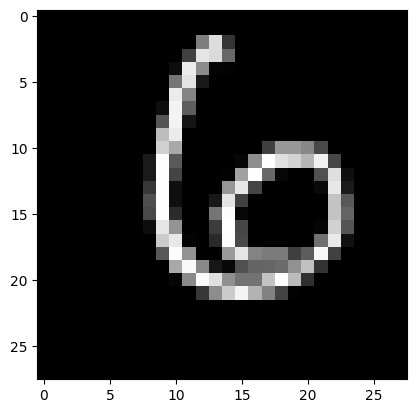

In [38]:
#Exemplo
plt.imshow(testX[100,:,:,0], cmap='gray');
np.argmax(modelo_mnist.predict(np.expand_dims(testX[100], axis=0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


4

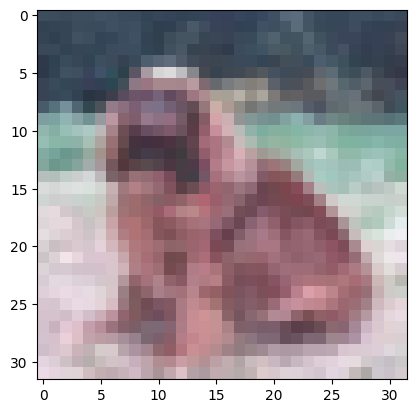

In [39]:
plt.imshow(X_test[101]);
np.argmax(modelo_cifar.predict(np.expand_dims(X_test[101], axis=0)))

Usaremos o último modelo treinado na validação cruzada k-fold para classificar qual número temos na imagem (podemos também salvar cada um dos modelos intermediários e usar o que apresentar maior performance ou fazer um comitê de votação com os 5 modelos disponíveis)

* temos que fazer uma expansão de dimensão para que nossa imagem tenha um formato 1 x 28 x 28 x 1. Isso é necessário pois treinamos nosso modelo usando mini conjuntos de imagens (como nosso batch size era de 32, o formato passado para o modelo a cada passo de treinamento era 32 x 28 x 28 x 1)

Houve muita diferença no desempenho da rede treinada quando comparado ao exemplo?  

* modelo.mnist: Acurácia: média=97.907 desvio=0.534
* modelo_cifar10: Acurácia: média=57.772 desvio=1.947

O modelo treinado para exemplo teva um desempenho muito superior ao 1 modelo treinado com o cifar. Tendo uma media de precisao 40% maior e um desvio padrao 3.6x maior.

# Experimente adicionar mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten e compare os resultados.

In [40]:
# definindo modelo
def define_model_cifar10_conv2_maxpool():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  ##Exercicio##
  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  ##Fim Exercicio##
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model_cifar10_conv2_maxpool = define_model_cifar10_conv2_maxpool()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4155 - loss: 1.6102 - val_accuracy: 0.5588 - val_loss: 1.2740
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6079 - loss: 1.1112 - val_accuracy: 0.6166 - val_loss: 1.0991
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6726 - loss: 0.9450 - val_accuracy: 0.6421 - val_loss: 1.0493
> 55.880
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6025 - loss: 1.1261 - val_accuracy: 0.6283 - val_loss: 1.0654
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6714 - loss: 0.9437 - val_accuracy: 0.6539 - val_loss: 1.0070
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7095 - loss: 0.8279 - val_accuracy: 0.6666 - val_loss: 0.9579
> 62.830
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6638 - loss: 0.9611 - val_accuracy: 0.6322 - val_loss: 1.0713
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7047

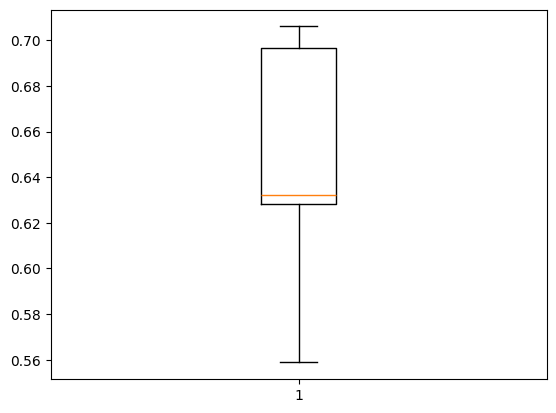

In [41]:
scores_cifar_conv2_maxpool = train(model=model_cifar10_conv2_maxpool)

media_cifar_conv2_maxpool = np.mean(scores_cifar_conv2_maxpool)*100
std_cifar_conv2_maxpool = np.std(scores_cifar_conv2_maxpool)*100

print(f'Acurácia: média={media_cifar_conv2_maxpool:.3f} desvio={std_cifar_conv2_maxpool:.3f}')
plt.boxplot(scores_cifar_conv2_maxpool)
plt.show()

A acuracia media do modelo aumentou em certa de 10% com a adicao de dois blocos com camadas Conv2d + maxpooling

# Seguindo o modelo modificado no item anterior, experimente adicionar um Dropout de 20% após cada camada MaxPooling.

In [42]:
# definindo modelo
def define_model_cifar10_conv2_maxpool_dropout():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  ##Exercicio##
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  ##Fim Exercicio##
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model_cifar10_conv2_maxpool_dropout = define_model_cifar10_conv2_maxpool_dropout()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3428 - loss: 1.7866 - val_accuracy: 0.5185 - val_loss: 1.3564
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5247 - loss: 1.3302 - val_accuracy: 0.5885 - val_loss: 1.1745
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5831 - loss: 1.1855 - val_accuracy: 0.5196 - val_loss: 1.4197
> 51.850
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5200 - loss: 1.3307 - val_accuracy: 0.5679 - val_loss: 1.2429
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5729 - loss: 1.1901 - val_accuracy: 0.5652 - val_loss: 1.2218
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6079 - loss: 1.1086 - val_accuracy: 0.5901 - val_loss: 1.1469
> 56.790
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5756 - loss: 1.1874 - val_accuracy: 0.5918 - val_loss: 1.1554
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.605

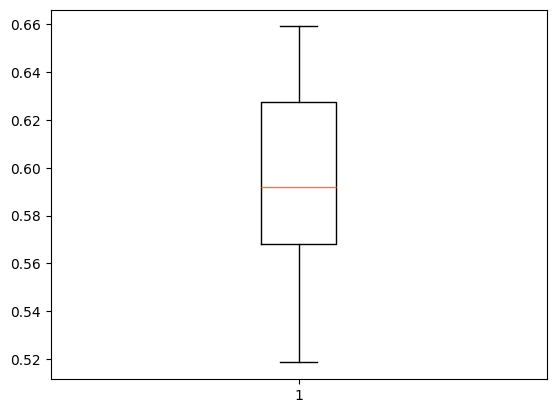

In [43]:
scores_cifar_conv2_maxpool_dropout = train(model=model_cifar10_conv2_maxpool_dropout)

media_cifar_conv2_maxpool_dropout = np.mean(scores_cifar_conv2_maxpool_dropout)*100
std_cifar_conv2_maxpool_dropout = np.std(scores_cifar_conv2_maxpool_dropout)*100

print(f'Acurácia: média={media_cifar_conv2_maxpool_dropout:.3f} desvio={std_cifar_conv2_maxpool_dropout:.3f}')

plt.boxplot(scores_cifar_conv2_maxpool_dropout)
plt.show()

##Resultados obtidos

In [44]:
resultados = [
    {"modelo:": "modelo_exemplo", "media": media_mnist, "std:" : std_mnist},
    {"modelo:": "cifar_base", "media": media_cifar, "std:" : std_cifar},
    {"modelo:": "cifa_conv2_maxpool", "media": media_cifar_conv2_maxpool, "std:" : std_cifar_conv2_maxpool},
    {"modelo:": "cifa_conv2_maxpool_dropout", "media": media_cifar_conv2_maxpool_dropout, "std:" : std_cifar_conv2_maxpool_dropout},
]
import pandas as pd
tabela_resultados = pd.DataFrame(resultados)

In [45]:
tabela_resultados

,modelo:,media,std:
0,modelo_exemplo,97.951667,0.467333
1,cifar_base,69.518000,7.197440
2,cifa_conv2_maxpool,64.441999,5.343704
3,cifa_conv2_maxpool_dropout,59.291999,4.843010
